In [1]:
# Phase 1 - Step 1: Load all CSV files (Training and Test sets)

import pandas as pd

# Load Training Data
train = pd.read_csv("Train-1542865627584.csv")  # Labels and provider-level info
train_beneficiary = pd.read_csv("Train_Beneficiarydata-1542865627584.csv") # Patient demographics and chronic conditions
train_inpatient = pd.read_csv("Train_Inpatientdata-1542865627584.csv")  # Hospital-based claims
train_outpatient = pd.read_csv("Train_Outpatientdata-1542865627584.csv")  # Clinic/OP claims

# Load corresponding test datasets
test = pd.read_csv("Test-1542969243754.csv")
test_beneficiary = pd.read_csv("Test_Beneficiarydata-1542969243754.csv")
test_inpatient = pd.read_csv("Test_Inpatientdata-1542969243754.csv")
test_outpatient = pd.read_csv("Test_Outpatientdata-1542969243754.csv")

In [2]:
# Step 2: Verify shapes of all loaded datasets
print("Train shape:", train.shape)
print("Train Beneficiary shape:", train_beneficiary.shape)
print("Train Inpatient shape:", train_inpatient.shape)
print("Train Outpatient shape:", train_outpatient.shape)

print("Test shape:", test.shape)
print("Test Beneficiary shape:", test_beneficiary.shape)
print("Test Inpatient shape:", test_inpatient.shape)
print("Test Outpatient shape:", test_outpatient.shape)

Train shape: (5410, 2)
Train Beneficiary shape: (138556, 25)
Train Inpatient shape: (40474, 30)
Train Outpatient shape: (517737, 27)
Test shape: (1353, 1)
Test Beneficiary shape: (63968, 25)
Test Inpatient shape: (9551, 30)
Test Outpatient shape: (125841, 27)


In [3]:
# Step 3: Merge inpatient, outpatient, beneficiary, and label data into one unified training dataset

# Add source label to each claim type
train_inpatient["Source"] = "Inpatient"
train_outpatient["Source"] = "Outpatient"

# Combine inpatient and outpatient claims into one dataset
train_claims = pd.concat([train_inpatient, train_outpatient], ignore_index=True)

# Merge with beneficiary data on BeneID
train_claims = train_claims.merge(train_beneficiary, on="BeneID", how="left")

# Merge with label data on Provider
train_full = train_claims.merge(train, on="Provider", how="left")

print("Merged training data shape:", train_full.shape)
train_full.head()

Merged training data shape: (558211, 56)


,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,...,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,PotentialFraud
0,BENE11001,CLM46614,2009-04-12,2009-04-18,PRV55912,26000,PHY390922,NaN,NaN,2009-04-12,...,1,1,2,1,1,36000,3204,60,70,Yes
1,BENE11001,CLM66048,2009-08-31,2009-09-02,PRV55907,5000,PHY318495,PHY318495,NaN,2009-08-31,...,1,1,2,1,1,36000,3204,60,70,No
2,BENE11001,CLM68358,2009-09-17,2009-09-20,PRV56046,5000,PHY372395,NaN,PHY324689,2009-09-17,...,1,1,2,1,1,36000,3204,60,70,No
3,BENE11011,CLM38412,2009-02-14,2009-02-22,PRV52405,5000,PHY369659,PHY392961,PHY349768,2009-02-14,...,1,2,2,1,1,5000,1068,250,320,No
4,BENE11014,CLM63689,2009-08-13,2009-08-30,PRV56614,10000,PHY379376,PHY398258,NaN,2009-08-13,...,2,1,2,2,2,21260,2136,120,100,No


In [4]:
# Step 4: Saved the merged dataset as CSV for later reuse and team sharing (especially due to GitHub size limits)

train_full.to_csv("train_full.csv", index=False)
print("Saved as train_full.csv")

Saved as train_full.csv


Fraud Class Distribution (Proportions):
PotentialFraud
No     0.618789
Yes    0.381211
Name: proportion, dtype: float64


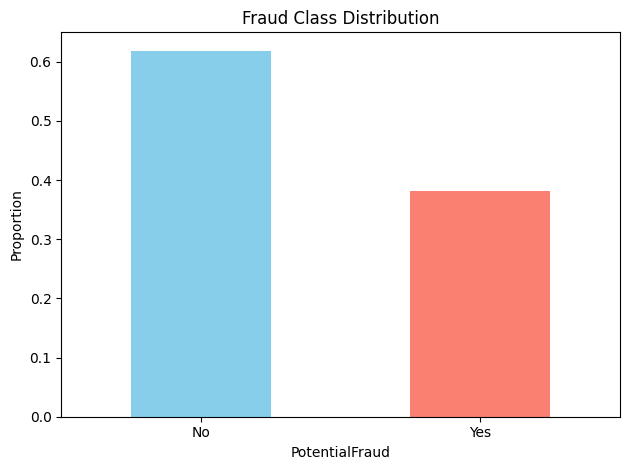

In [5]:
# Phase 2 - Step 1: Visualize class imbalance in fraud labels
import matplotlib.pyplot as plt

# Calculate proportion of fraud vs. non-fraud cases
fraud_counts = train_full['PotentialFraud'].value_counts(normalize=True)
print("Fraud Class Distribution (Proportions):")
print(fraud_counts)

# Bar plot to show imbalance
fraud_counts.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title("Fraud Class Distribution")
plt.ylabel("Proportion")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

      Provider  TotalReimbursement
818   PRV52019             5996050
3557  PRV55462             4713830
4446  PRV56560             3212000
2705  PRV54367             3133880
3000  PRV54742             2969530
3358  PRV55209             2914700
2176  PRV53706             2831940
4334  PRV56416             2744870
3373  PRV55230             2612740
1071  PRV52340             2540130


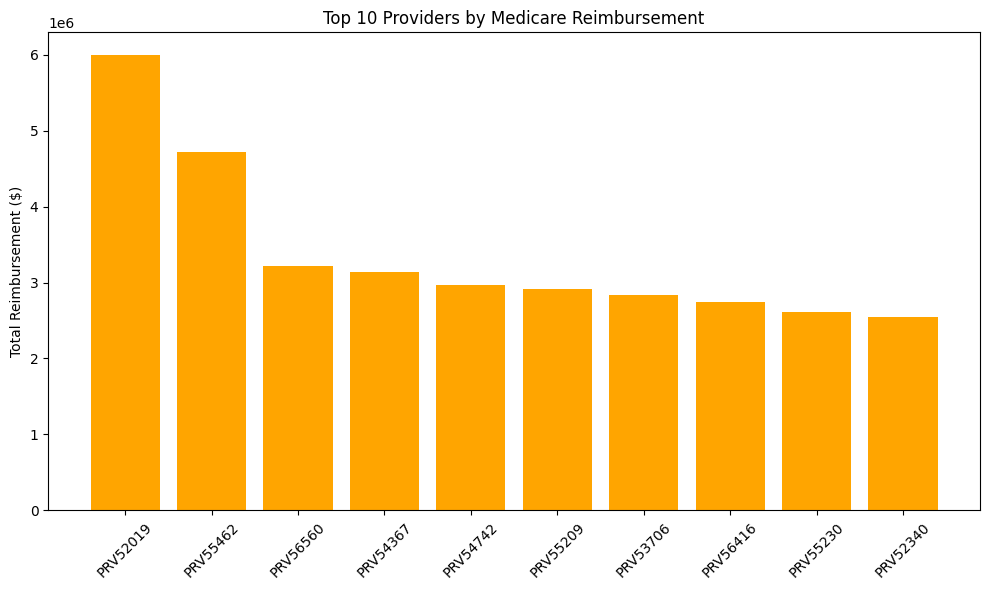

In [6]:
# Phase 2 - Step 2: Identify providers with highest total Medicare reimbursements
# Sum reimbursement amount per provider
reimb_per_provider = train_full.groupby('Provider')['InscClaimAmtReimbursed'].sum().reset_index()
reimb_per_provider.columns = ['Provider', 'TotalReimbursement']

# Get top 10 providers by total reimbursement
top_reimb = reimb_per_provider.sort_values(by='TotalReimbursement', ascending=False).head(10)
print(top_reimb)

# Plot top 10 reimbursed providers
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.bar(top_reimb['Provider'], top_reimb['TotalReimbursement'], color='orange')
plt.xticks(rotation=45)
plt.ylabel("Total Reimbursement ($)")
plt.title("Top 10 Providers by Medicare Reimbursement")
plt.tight_layout()
plt.show()

      Provider  InpatientClaimCount  OutpatientClaimCount  TotalClaims
363   PRV51459                  0.0                8240.0       8240.0
2250  PRV53797                  0.0                4739.0       4739.0
455   PRV51574                  0.0                4444.0       4444.0
2335  PRV53918                  0.0                3588.0       3588.0
3113  PRV54895                  3.0                3433.0       3436.0
3363  PRV55215                143.0                3250.0       3393.0
853   PRV52064                 38.0                2806.0       2844.0
4004  PRV56011                  0.0                2833.0       2833.0
3195  PRV55004                  3.0                2396.0       2399.0
5032  PRV57306                  0.0                2315.0       2315.0


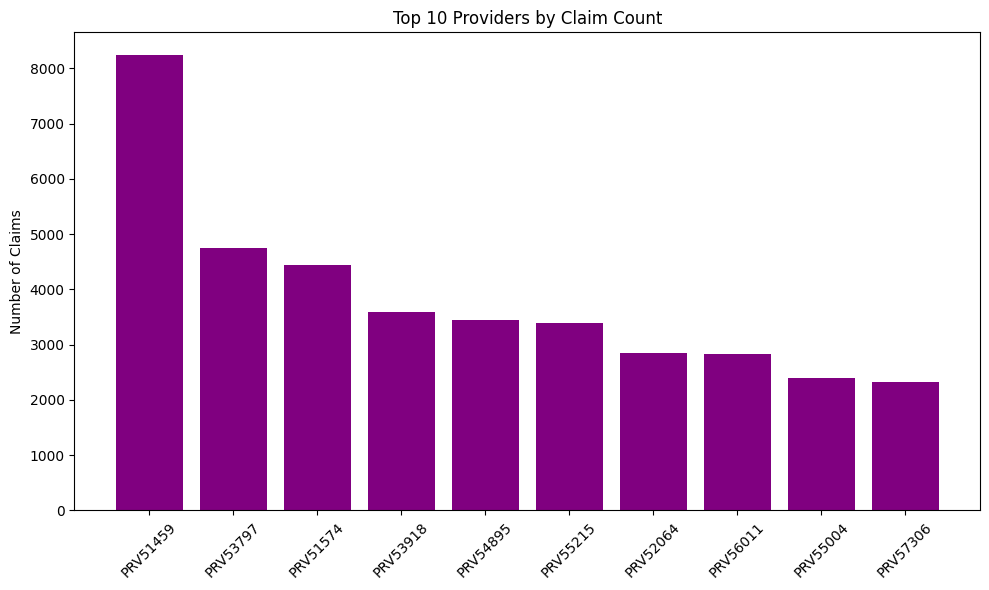

In [7]:
#Phase 2 - Step 3: Analyze claim volume per provider

# Count inpatient claims per provider
inpatient_counts = train_inpatient['Provider'].value_counts().reset_index()
inpatient_counts.columns = ['Provider', 'InpatientClaimCount']

# Count outpatient claims per provider
outpatient_counts = train_outpatient['Provider'].value_counts().reset_index()
outpatient_counts.columns = ['Provider', 'OutpatientClaimCount']

# Merge inpatient and outpatient counts
claim_counts = pd.merge(inpatient_counts, outpatient_counts, on='Provider', how='outer').fillna(0)

# Compute total claims per provider
claim_counts['TotalClaims'] = claim_counts['InpatientClaimCount'] + claim_counts['OutpatientClaimCount']

# Display top 10 providers by number of claims
top_claims = claim_counts.sort_values(by='TotalClaims', ascending=False).head(10)
print(top_claims)

# Plot
plt.figure(figsize=(10, 6))
plt.bar(top_claims['Provider'], top_claims['TotalClaims'], color='purple')
plt.xticks(rotation=45)
plt.ylabel("Number of Claims")
plt.title("Top 10 Providers by Claim Count")
plt.tight_layout()
plt.show()

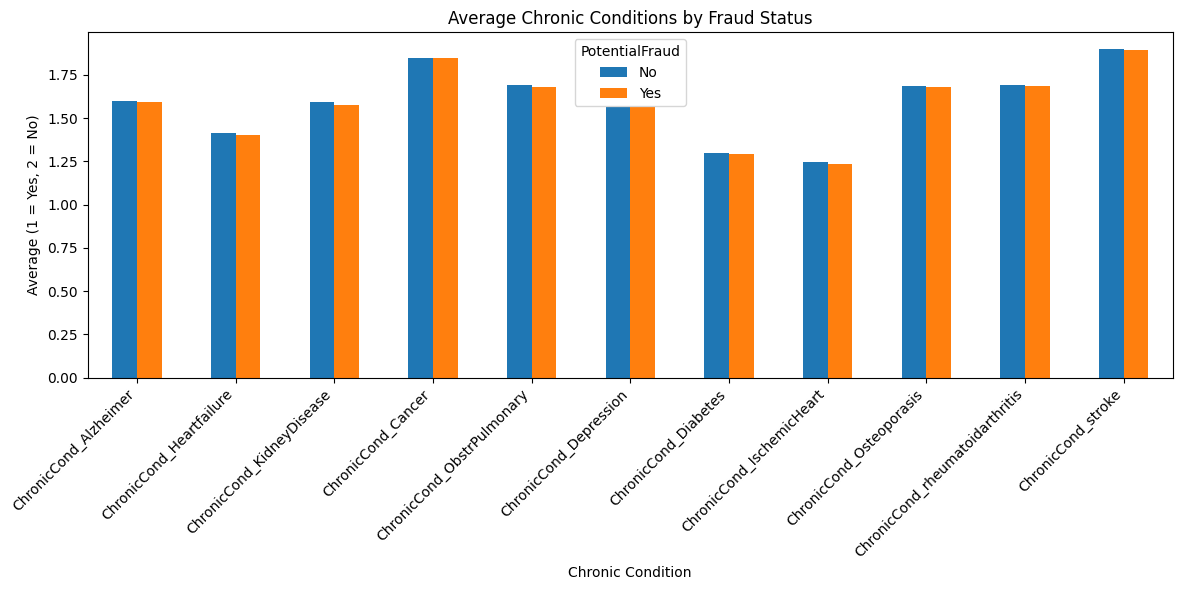

In [8]:
#Phase 5 - Step 4: Compare chronic condition prevalence between fraudulent and non-fraudulent providers
# Define chronic condition columns
chronic_cols = [
    "ChronicCond_Alzheimer", "ChronicCond_Heartfailure", "ChronicCond_KidneyDisease",
    "ChronicCond_Cancer", "ChronicCond_ObstrPulmonary", "ChronicCond_Depression",
    "ChronicCond_Diabetes", "ChronicCond_IschemicHeart", "ChronicCond_Osteoporasis",
    "ChronicCond_rheumatoidarthritis", "ChronicCond_stroke"
]

# Compute average value per condition grouped by fraud label
chronic_means = train_full.groupby("PotentialFraud")[chronic_cols].mean()

# Transpose for visualization
plot_data = chronic_means.T

# Plot chronic condition patterns
import matplotlib.pyplot as plt
plot_data.plot(kind='bar', figsize=(12, 6))
plt.title("Average Chronic Conditions by Fraud Status")
plt.xlabel("Chronic Condition")
plt.ylabel("Average (1 = Yes, 2 = No)")
plt.xticks(rotation=45, ha='right')
plt.legend(title='PotentialFraud')
plt.tight_layout()
plt.show()

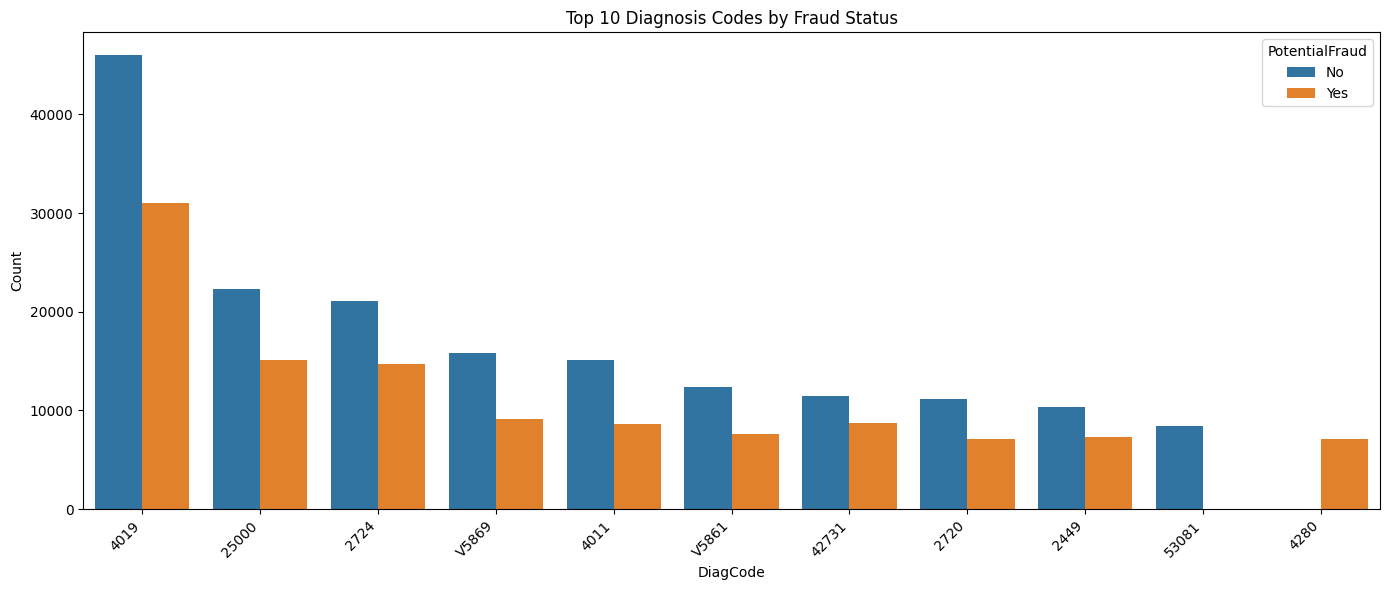

In [42]:
#Phase 2 - Step 5: Examine most common diagnosis codes by fraud status
import seaborn as sns
import matplotlib.pyplot as plt

# Collect all diagnosis code columns
diag_cols = [col for col in train_full.columns if col.startswith("ClmDiagnosisCode")]
diagnosis_data = train_full[diag_cols + ['PotentialFraud']].copy()

# Melt into long format to count code occurrences
diagnosis_melted = diagnosis_data.melt(
    id_vars='PotentialFraud',
    value_vars=diag_cols,
    var_name='DiagCodeType',
    value_name='DiagCode'
).dropna()

# Count top diagnosis codes by fraud status
top_codes = (
    diagnosis_melted.groupby(['PotentialFraud', 'DiagCode'])
    .size()
    .reset_index(name='Count')
    .sort_values(['PotentialFraud', 'Count'], ascending=[True, False])
)

# Take top 10 for each group
top_10_codes = top_codes.groupby('PotentialFraud').head(10)

# Plot
plt.figure(figsize=(14, 6))
sns.barplot(data=top_10_codes, x='DiagCode', y='Count', hue='PotentialFraud')
plt.title("Top 10 Diagnosis Codes by Fraud Status")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [43]:
#Phase 2 - Step 6-A: Drop unnecessary columns and prepare X and y for modeling
# Drop ID and date-related columns (not useful for modeling) **JUST MESSING AROUND, WILL DELETE LATE**
drop_cols = [
    'BeneID', 'ClaimID', 'AttendingPhysician', 'OperatingPhysician', 'OtherPhysician',
    'AdmissionDt', 'ClaimStartDt', 'ClaimEndDt'
]

# Drop those columns and isolate the feature set
X = train_full.drop(columns=drop_cols + ['PotentialFraud'])  # drop label too for now
y = train_full['PotentialFraud'].map({'No': 0, 'Yes': 1})     # convert label to 0/1

In [44]:
# Step 6-B: Final cleanup – drop string IDs and ensure numeric-only features

# Drop remaining string-based or date columns that can't help in modeling
X = X.drop(columns=['Provider', 'DischargeDt'])

# Convert all columns to numeric (safe guard) and fill missing values with 0
X = X.apply(pd.to_numeric, errors='coerce')
X = X.fillna(0)

# Confirm final feature matrix shape
print("Cleaned feature matrix shape:", X.shape)
print("Target vector shape:", y.shape)
X.head()

Cleaned feature matrix shape: (558211, 45)
Target vector shape: (558211,)


,InscClaimAmtReimbursed,ClmAdmitDiagnosisCode,DeductibleAmtPaid,DiagnosisGroupCode,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,...,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt
0,26000,7866.0,1068.0,201.0,1970.0,4019.0,5853.0,7843.0,2768.0,71590.0,...,1,1,1,2,1,1,36000,3204,60,70
1,5000,6186.0,1068.0,750.0,6186.0,2948.0,56400.0,0.0,0.0,0.0,...,1,1,1,2,1,1,36000,3204,60,70
2,5000,29590.0,1068.0,883.0,29623.0,30390.0,71690.0,34590.0,0.0,32723.0,...,1,1,1,2,1,1,36000,3204,60,70
3,5000,431.0,1068.0,67.0,43491.0,2762.0,7843.0,32723.0,0.0,4254.0,...,1,1,2,2,1,1,5000,1068,250,320
4,10000,78321.0,1068.0,975.0,42.0,3051.0,34400.0,5856.0,42732.0,486.0,...,1,2,1,2,2,2,21260,2136,120,100


In [37]:
# Step 7: Split data into training and validation sets

from sklearn.model_selection import train_test_split

# Stratify ensures class balance is maintained
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)

Training set shape: (446568, 45)
Validation set shape: (111643, 45)


In [39]:
# Step 8: Train and evaluate a Logistic Regression model

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Initialize and train model
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)

# Predict on validation set
y_pred = lr.predict(X_val)

# Evaluation metrics
print("Classification Report (Logistic Regression):")
print(classification_report(y_val, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred))

Classification Report (Logistic Regression):
              precision    recall  f1-score   support

           0       0.63      0.95      0.76     69083
           1       0.57      0.10      0.17     42560

    accuracy                           0.63    111643
   macro avg       0.60      0.53      0.47    111643
weighted avg       0.61      0.63      0.54    111643

Confusion Matrix:
[[65810  3273]
 [38204  4356]]


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [40]:
# Step 9: Train and evaluate a Random Forest Classifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Initialize and train model
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

# Predict on validation set
y_pred_rf = rf.predict(X_val)

# Evaluation metrics
print("Classification Report (Random Forest):")
print(classification_report(y_val, y_pred_rf))

print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred_rf))

Classification Report (Random Forest):
              precision    recall  f1-score   support

           0       0.74      0.85      0.79     69083
           1       0.68      0.51      0.59     42560

    accuracy                           0.72    111643
   macro avg       0.71      0.68      0.69    111643
weighted avg       0.72      0.72      0.71    111643

Confusion Matrix:
[[59019 10064]
 [20751 21809]]


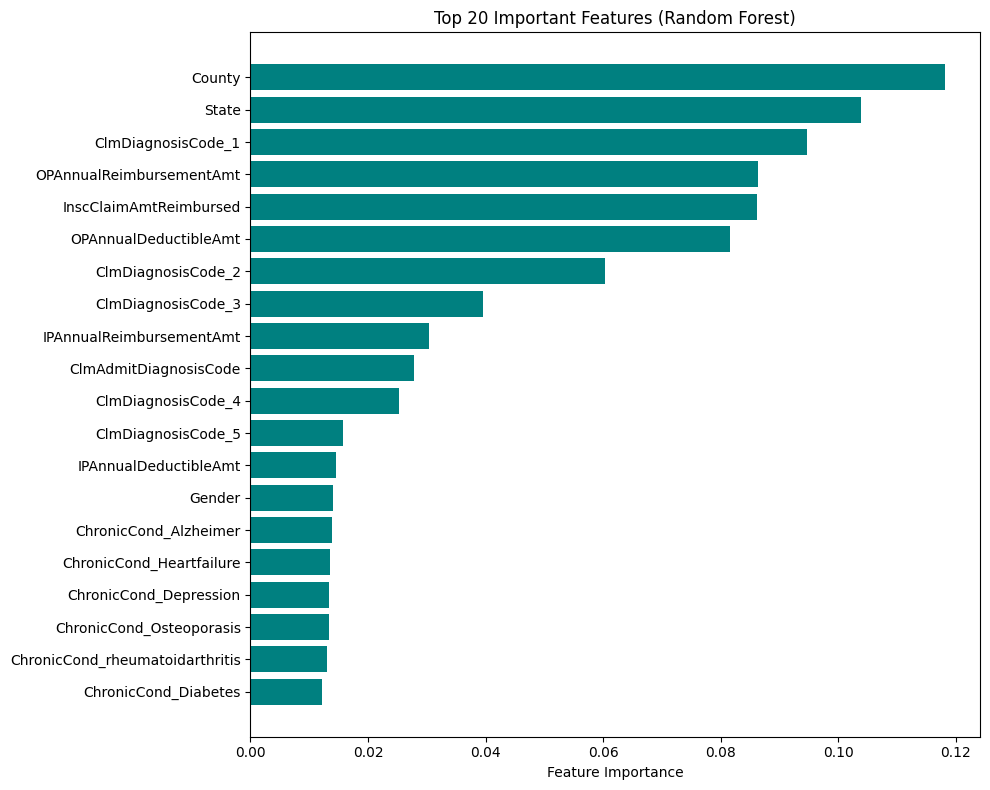

,Feature,Importance
27,County,0.118236
26,State,0.103940
4,ClmDiagnosisCode_1,0.094695
43,OPAnnualReimbursementAmt,0.086420
0,InscClaimAmtReimbursed,0.086140
44,OPAnnualDeductibleAmt,0.081606
5,ClmDiagnosisCode_2,0.060300
6,ClmDiagnosisCode_3,0.039653
41,IPAnnualReimbursementAmt,0.030453
1,ClmAdmitDiagnosisCode,0.027847


In [41]:
# Step 10: Visualize top 20 most important features from Random Forest

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Get feature importances from model
importances = rf.feature_importances_
feature_names = X.columns

# Build a DataFrame for sorted importances
feat_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot top 20 features
plt.figure(figsize=(10, 8))
plt.barh(feat_imp_df['Feature'][:20][::-1], feat_imp_df['Importance'][:20][::-1], color='teal')
plt.xlabel('Feature Importance')
plt.title('Top 20 Important Features (Random Forest)')
plt.tight_layout()
plt.show()

# Print top 20 features in table form
feat_imp_df.head(20)